In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [113]:
df=pd.read_csv('time.csv',index_col='date',parse_dates=True)
df=df.iloc[:,:-1]
df['consumption'] = df['consumption'].astype(int)
df.dropna()
df.head(5)

,connection,population,actual_limit,factor,consumption
date,,,,,
2017-01-01,4037,19373,2615355,1.193640,3121791
2017-01-02,4038,19378,2616030,1.167478,3054157
2017-01-03,4039,19383,2616705,1.145279,2996857
2017-01-04,4039,19383,2616705,1.118182,2925951
2017-01-05,4040,19387,2617245,1.136099,2973448


<Axes: xlabel='date'>

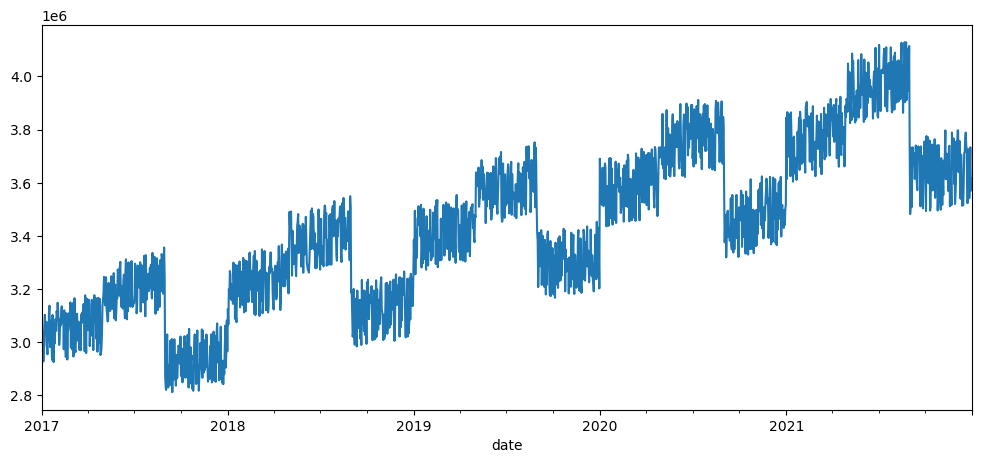

In [114]:
df['consumption'].plot(figsize=(12,5))

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   connection    1826 non-null   int64  
 1   population    1826 non-null   int64  
 2   actual_limit  1826 non-null   int64  
 3   factor        1826 non-null   float64
 4   consumption   1826 non-null   int32  
dtypes: float64(1), int32(1), int64(3)
memory usage: 78.5 KB


In [116]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print('ADF: ',dftest[0])
    print('P-Value: ',dftest[1])
    print('No of Lags: ',dftest[2])
    print('Num of Observation: ',dftest[3])
    print('Critical Values: ')
    for key,val in dftest[4].items():
        print("\t",key,": ",val)

In [117]:
ad_test(df['consumption'])

ADF:  -2.047604505154396
P-Value:  0.26609784403695014
No of Lags:  9
Num of Observation:  1816
Critical Values: 
	 1% :  -3.4339560393603112
	 5% :  -2.8631328654399884
	 10% :  -2.5676179883293875


In [118]:
from pmdarima import auto_arima


In [119]:
stepwise_fit = auto_arima(df['consumption'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=47096.936, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47580.154, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47250.033, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47101.937, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47578.165, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=47097.553, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=47088.591, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=47086.812, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=47093.438, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=47160.191, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=47085.733, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=47100.707, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=47248.152, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=47087.512, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=47095.748, Time=0.89

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1826
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -23539.866
Date:                Fri, 15 Sep 2023   AIC                          47085.733
Time:                        23:11:53   BIC                          47102.261
Sample:                    01-01-2017   HQIC                         47091.830
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1470      0.007     21.785      0.000       0.134       0.160
ma.L1         -0.7047      0.010    -71.200      0.000      -0.724      -0.685
sigma2      8.327e+09   2.72e-13   3.06e+22      0.000    8.33e+09    8.33e+09
===================================================================================
Ljung-Box (L1) (Q):                  11.28   Jarque-Bera (JB):              6876.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.84
Prob(H) (two-sided):                  0.37   Kurtosis:                        12.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.55e+36. Standard errors may be unstable.
"""

Best model:  ARIMA(1,1,1)(0,0,0)[0] 

In [120]:
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [121]:
train = df.iloc[:-365]
test = df.iloc[-365:]
print(train.shape,test.shape)

(1461, 5) (365, 5)


In [122]:
model= SARIMAX(endog=train['consumption'],order=(3,0,2),seasonal_order=(1,0,1,12))
model2 = ARIMA(train['consumption'],order=(1,1,1),seasonal_order=(1,0,1,12))
model_fit= model.fit()
model2_fit = model2.fit()


In [123]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          consumption   No. Observations:                 1461
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood              -18692.086
Date:                              Fri, 15 Sep 2023   AIC                          37400.173
Time:                                      23:11:58   BIC                          37442.468
Sample:                                  01-01-2017   HQIC                         37415.950
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0036      0.036     -0.101      0.919      -0.074       0.067
ar.L2          0.9894      0.018     54.356      0.000       0.954       1.025
ar.L3          0.0141      0.033      0.434      0.665      -0.050       0.078
ma.L1          0.2588      0.026      9.991      0.000       0.208       0.310
ma.L2         -0.7298      0.025    -29.591      0.000      -0.778      -0.681
ar.S.L12       0.9253      0.307      3.015      0.003       0.324       1.527
ma.S.L12      -0.9306      0.298     -3.121      0.002      -1.515      -0.346
sigma2      7.698e+09   3.33e-11   2.31e+20      0.000     7.7e+09     7.7e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                11.40
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.45e+35. Standard errors may be unstable.
"""

In [124]:
start_date = '2020-01-01'
end_date = '2020-12-30'
train['prediction']= model_fit.predict(start=start_date, end=end_date,dynamic=False)
train['prediction2']=model2_fit.predict(start=start_date, end=end_date,dynamic=False)


<Axes: xlabel='date'>

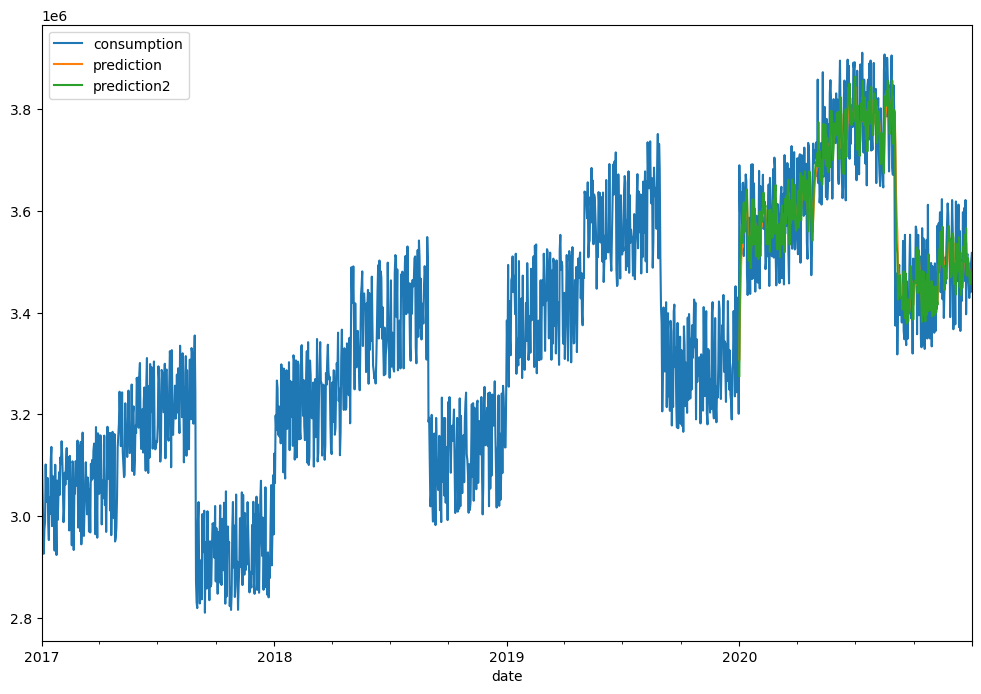

In [125]:
train[['consumption','prediction','prediction2']].plot(figsize=(12,8))

In [126]:
test.head(5),test.tail(5)

(            connection  population  actual_limit    factor  consumption
 date                                                                   
 2021-01-01        4962       23812       3214620  1.196174      3845245
 2021-01-02        4964       23822       3215970  1.123770      3614011
 2021-01-03        4965       23827       3216645  1.201793      3865741
 2021-01-04        4965       23827       3216645  1.172831      3772579
 2021-01-05        4966       23831       3217185  1.168712      3759964,
             connection  population  actual_limit    factor  consumption
 date                                                                   
 2021-12-27        5170       24810       3349350  1.087424      3642163
 2021-12-28        5170       24810       3349350  1.114535      3732966
 2021-12-29        5171       24815       3350025  1.065369      3569011
 2021-12-30        5172       24820       3350700  1.069975      3585164
 2021-12-31        5172       24820       3350700 

In [216]:
# # Define the number of future periods to forecast
# forecast_periods = 365  # Adjust as needed to match the length of the forecasted values

# # Extend the time index to include future dates
# start_date = pd.to_datetime('2021-01-01')  # Replace with your desired start date
# end_date = start_date + pd.DateOffset(days=forecast_periods - 1)  # Extend by 'forecast_periods - 1'

# future_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
forecast_df= pd.DataFrame()
# forecast_df['forecast_data']= model_fit.predict(start='2020-01-01', end='2020-12-30',dynamic=False)
# forecast = model_fit.get_forecast(steps=365)
# forecast_df['forecast_data']= forecast.predicted_mean
# forecast_df['forecast_data']=forecast_df['forecast_data'].astype(int)
# forecast_ci = forecast.conf_int()
# forecast2 = model2_fit.get_forecast(steps=365)
# forecast_df['forecast_data2']= forecast2.predicted_mean
# forecast_df['forecast_data2']=forecast_df['forecast_data2'].astype(int)
# forecast_ci2 = forecast2.conf_int()
forecast_df['forecast_data']= model_fit.predict(start=1462,end=1826,dynamic=True)
forecast_df['forecast_data2']= model2_fit.predict(start=1462,end=1826,dynamic=True)

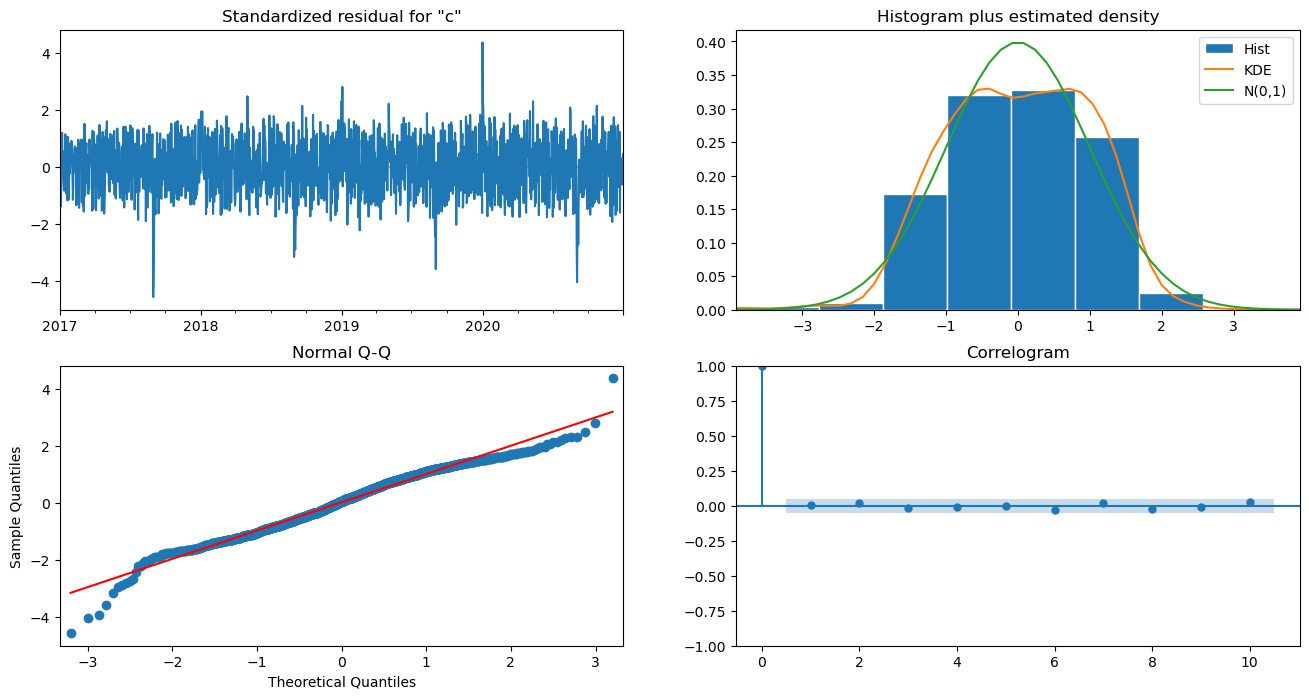

In [217]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [218]:
forecast_df

,forecast_data,forecast_data2
2021-01-02,3.489051e+06,3.493169e+06
2021-01-03,3.488079e+06,3.492225e+06
2021-01-04,3.488994e+06,3.492274e+06
2021-01-05,3.486220e+06,3.492281e+06
2021-01-06,3.486793e+06,3.492205e+06
...,...,...
2021-12-28,3.443914e+06,3.492241e+06
2021-12-29,3.443760e+06,3.492241e+06
2021-12-30,3.443679e+06,3.492241e+06
2021-12-31,3.443347e+06,3.492241e+06


In [219]:
forecast_df.shape,test.shape

((365, 2), (365, 5))

In [220]:
forecast_df.index=test.index

In [221]:
forecast_df['actual_data']=test['consumption']

<Axes: xlabel='date'>

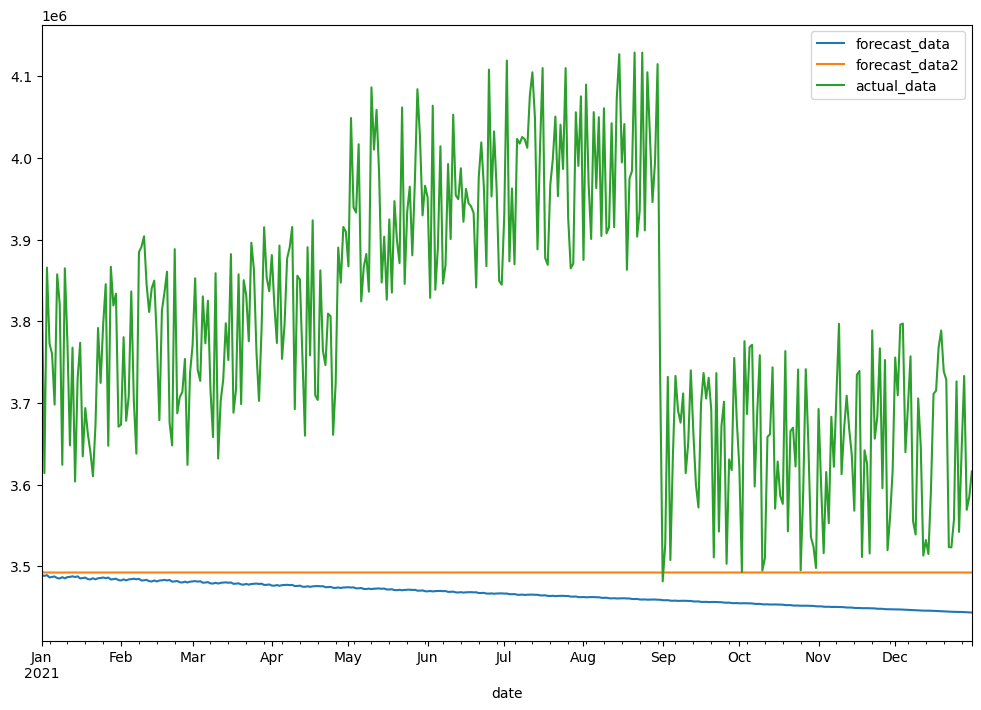

In [222]:
forecast_df[['forecast_data','forecast_data2','actual_data']].plot(figsize=(12,8))

In [223]:
# import itertools
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# # import statsmodels.api as sm
# import warnings
# warnings.filterwarnings('ignore')


(1, 0, 2, 1, 0, 1) : 12.0
(1, 0, 2, 2, 0, 1) : 14.0
(2, 0, 2, 2, 0, 2) : 18.0

In [224]:

# # Define ranges for order parameters
# p_values = [1, 2]
# d_values = [0, 1]
# q_values = [0, 1, 2]
# P_values = [0, 1, 2]
# D_values = [0, 1]
# Q_values = [0, 1, 2]

# # Perform grid search
# best_aic = float('inf')
# print(best_aic)
# best_order = None

# for order in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
#     try:
#         model = SARIMAX(train['consumption'], order=(order[0],order[1],order[2]), seasonal_order=(order[3], order[4], order[5], 4))
#         results = model.fit()
#         aic = results.aic
#         print(order,':',aic)
#         if aic < best_aic:
#             print('----------------------------------->',order,':',aic)
#             best_aic = aic
#             best_order = order
#     except:
#         continue

# print("Best SARIMA Order:", best_order)

In [225]:
df.head(5)

,connection,population,actual_limit,factor,consumption,yearly Difference
date,,,,,,
2017-01-01,4037,19373,2615355,1.193640,3121791,NaN
2017-01-02,4038,19378,2616030,1.167478,3054157,NaN
2017-01-03,4039,19383,2616705,1.145279,2996857,NaN
2017-01-04,4039,19383,2616705,1.118182,2925951,NaN
2017-01-05,4040,19387,2617245,1.136099,2973448,NaN


In [226]:
df['yearly Difference']=df['consumption']-df['consumption'].shift(365)
df['yearly Difference']

date
2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
2017-01-04         NaN
2017-01-05         NaN
                ...   
2021-12-27    212936.0
2021-12-28    236289.0
2021-12-29    128535.0
2021-12-30     83701.0
2021-12-31     98318.0
Name: yearly Difference, Length: 1826, dtype: float64

In [227]:
ad_test(df['yearly Difference'].dropna())

ADF:  -37.440418006631965
P-Value:  0.0
No of Lags:  0
Num of Observation:  1460
Critical Values: 
	 1% :  -3.434836872962171
	 5% :  -2.863521656701378
	 10% :  -2.567825016419591


<Axes: xlabel='date'>

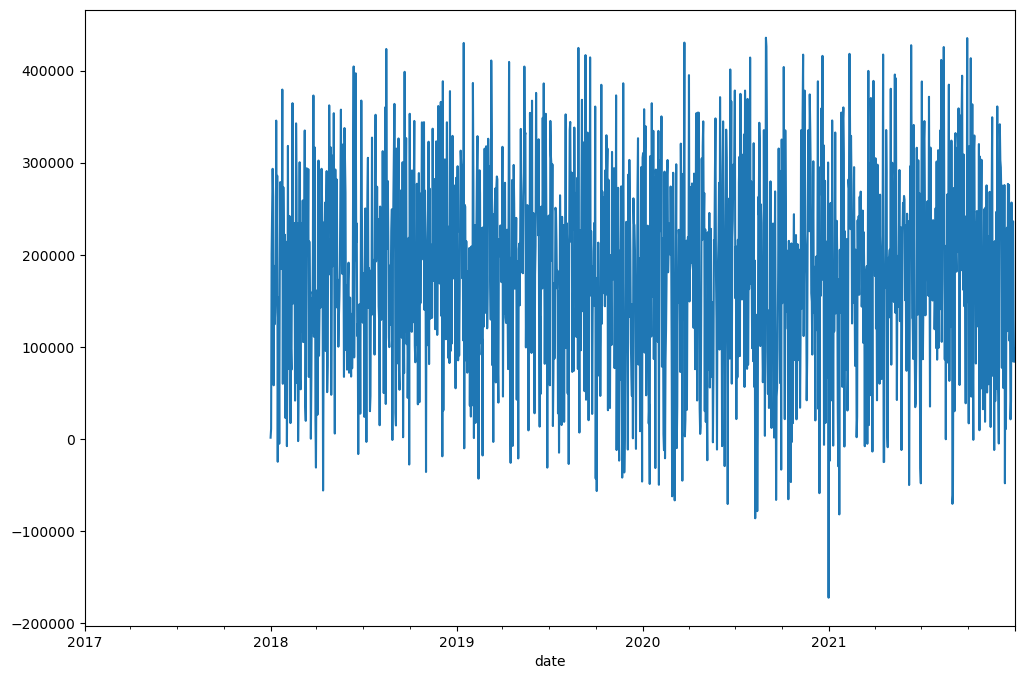

In [228]:
df['yearly Difference'].plot(figsize=(12,8))